# RVFL


Over the last three decades, randomization based methods, including random
projection [29], random forests [30], bagging [31], stochastic configuration networks (SCN) [32, 33], and random vector functional link networks (RVFL) [19],
etc., play important roles in machine learning community. We refer to [34, 35] for
great surveys of the randomized neural networks.
The RVFL presented first by Pao et. al. [19] is one of most popular single layer
feedforward neural networks due to its universal approximation ability and great
generalization performance.

<img src="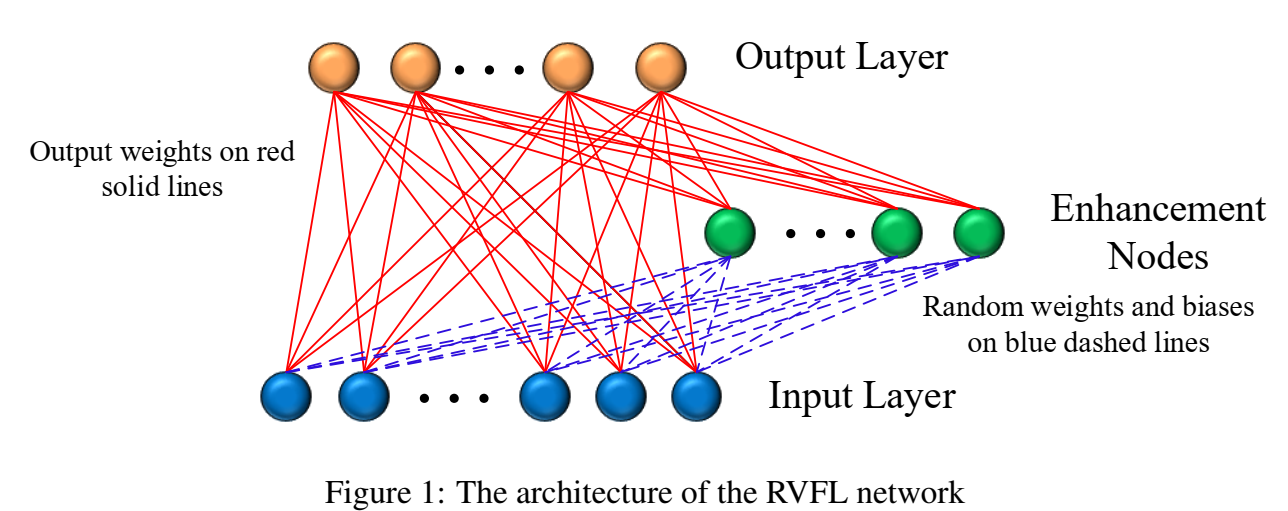
">

<img src="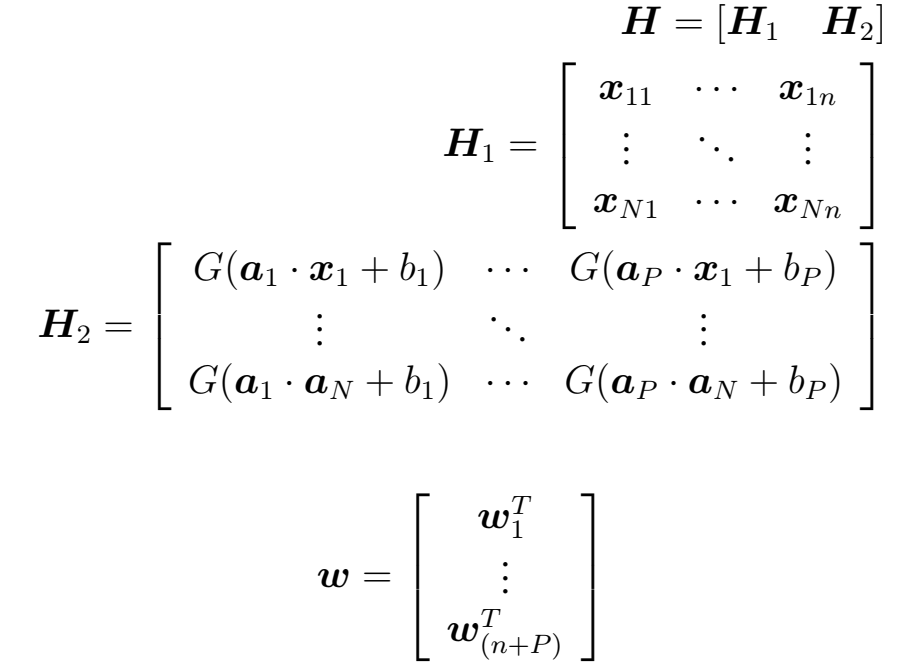
">

<img src="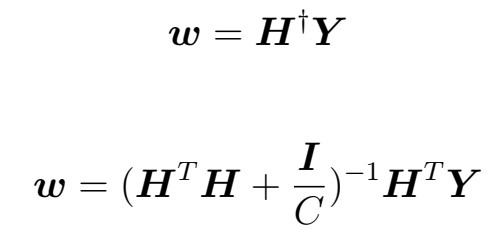
">

# Implementation

Based on https://github.com/pablozhang/RVFL_plus


### 代码解析

Forward Propagation:  
```
h = self._activation_dict[self.activation_name](x.dot(self.weights) + self.biases)
h = np.hstack((h, x))
t = h.dot(self.beta)
```

Parameter Initialization:  
$ A_{ij} \in (-1, 1) $, $ b_{i} \in (-1, 1)  $

Fit/Solve:  
$ T = [G( XA + b ) \,\,\, X] B $   
define $ H = [G( XA + b ) \,\,\, X] $ , then $ B = H^{+} T $  

<b>通过 $ H = [G( XA + b ) \,\,\, X] $ 在模型中同时引入了非线性与线性的表达/拟合能力。</b>

### Moore–Penrose inverse

$ H^{+} $ is the Moore–Penrose inverse of H. It is the most widely known generalization of the inverse matrix.  
The term pseudoinverse, without further specification, is often used to indicate the Moore–Penrose inverse. The term generalized inverse is sometimes used as a synonym for pseudoinverse.  
A common use of the pseudoinverse is to compute a "best fit" (least squares) solution to a system of linear equations that lacks a unique solution.  

In [6]:
%run "../../machine learning/source/18. pyNNRW/github/src/pyNNRW/RVFL.py"

<Figure size 432x288 with 0 Axes>

## 案例1：一维数据的回归问题

(158, 1) (40, 1) (158, 1) (40, 1)


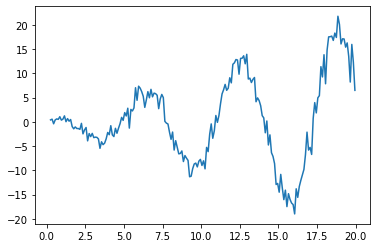

In [7]:
from sklearn.cluster import k_means
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

# from elm import ELMClassifier, ELMRegressor, GenELMClassifier, GenELMRegressor
# from random_layer import RandomLayer, MLPRandomLayer, RBFRandomLayer, GRBFRandomLayer

def make_toy():
    x = np.arange(0.25,20,0.1)
    y = x*np.cos(x)+0.5*np.sqrt(x)*np.random.randn(x.shape[0])
    x = x.reshape(-1,1)
    y = y.reshape(-1,1)
    return x, y

xtoy, ytoy = make_toy()
# xtoy, ytoy = stdsc.fit_transform(xtoy), stdsc.fit_transform(ytoy)
x_train, x_test, t_train, t_test = train_test_split(xtoy, ytoy, test_size=0.2)
plt.plot(xtoy, ytoy)
print(x_train.shape, x_test.shape, t_train.shape, t_test.shape)

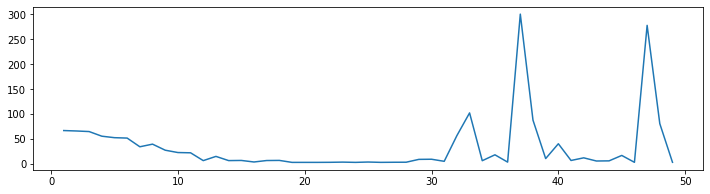

In [8]:
Ls = list(range(1, 50, 1))

plt.figure(figsize = (12,3))

MSEs = []
for L in Ls:
    rvfl = RVFL(type='regression', hidden_nodes = L)
    rvfl.fit(x_train, t_train)
    t_pred = rvfl.predict(x_test)
    MSE = np.mean((t_test - t_pred)**2)
    MSEs.append(MSE)
plt.plot(Ls, MSEs)

观察点：
1. MSE 随着 Hidden Layer的神经元数量L增加而减小，在L = 17附近，收敛到极小值。L影响模型的表达能力/复杂度  
2. 与ELM的结果类似

MSE on test set =  3.6683790589080885


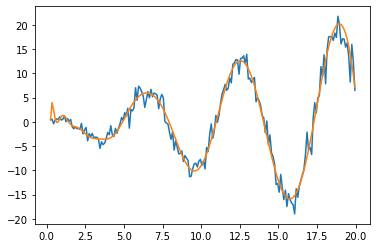

In [9]:
rvfl = RVFL(type='regression', hidden_nodes = 17)
rvfl.fit(x_train, t_train)
t_pred = rvfl.predict(x_test)
MSE = np.mean((t_test - t_pred)**2)
print("MSE on test set = ", MSE)
plt.plot(xtoy, ytoy, xtoy, rvfl.predict(xtoy))

## 案例2： Iris Dataset

In [14]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

# ===============================
# Load dataset
# ===============================
iris = load_iris()
n_classes = len(set(iris.target))
# stdsc = StandardScaler()
# irisx = stdsc.fit_transform(iris.data)
x_train, x_test, t_train, t_test = train_test_split(iris.data, iris.target, test_size=0.2)
# RVFL internally converts y to one-hot-encoding
# t_train = to_categorical(t_train, n_classes).astype(np.float32)
# t_test = to_categorical(t_test, n_classes).astype(np.float32)
# print(x_train.shape, x_test.shape, t_train.shape, t_test.shape)

# ===============================
# Instantiate
# ===============================
clf = RVFLClassifier(n_hidden_nodes = x_train.shape[1])

# ===============================
# Training
# ===============================
clf.fit(x_train, t_train)

# ===============================
# Validation
# ===============================
t_pred = clf.predict(x_test)
ACC = np.mean(t_test == t_pred)
print("ACC on test set = ", ACC)

ACC on test set =  0.9666666666666667


观察点：  
1. 由于没有类似于梯度下降的迭代过程，求解速度极快。  
1. 由于权重矩阵A和偏置项b的随机性，每次运行结果不同。可以运行多次，选取最优  
2. 一步到位求解得到权重矩阵B，由于随机性的引入，CV上的准确率有可能高于训练集  

## 案例3： MNIST

In [15]:
from tensorflow.keras.datasets import mnist
import os
import numpy as np

n_hidden_nodes = 1000
loss = 'mean_squared_error' # 'mean_absolute_error'
activation = 'sigmoid' # 'identity'

# ===============================
# Load dataset
# ===============================
n_classes = 10
(x_train, t_train), (x_test, t_test) = mnist.load_data()

# ===============================
# Preprocess
# ===============================
x_train = x_train.reshape(-1, 28**2)
x_test = x_test.reshape(-1, 28**2)

# ===============================
# Instantiate
# ===============================
clf = RVFLClassifier(n_hidden_nodes = x_train.shape[1])

# ===============================
# Training
# ===============================
clf.fit(x_train, t_train)

# ===============================
# Validation
# ===============================
t_pred = clf.predict(x_test)
ACC = np.mean(t_test == t_pred)
print("ACC on test set = ", ACC)

C:\Users\eleve\Documents\codex\py\machine learning\source\18. pyNNRW\github\src\pyNNRW\RVFL.py:39: RuntimeWarning: overflow encountered in exp
  self._activation_dict = {'sigmoid': lambda x : 1.0 / (1.0 + np.exp(-x)),


ACC on test set =  0.9191


C:\Users\eleve\Documents\codex\py\machine learning\source\18. pyNNRW\github\src\pyNNRW\RVFL.py:39: RuntimeWarning: overflow encountered in exp
  self._activation_dict = {'sigmoid': lambda x : 1.0 / (1.0 + np.exp(-x)),
